## PROFILOWANIE UCZESTNIKÓW SPEED DATINGU - ANALIZA

Meeter, aplikacja randkowa online, przygotowuje nową strategię marketingową i chciałaby wdrożyć "inteligentne", czyli ukierunkowane, reklamy dla swoich największych grup klientów. W związku z tym zorganizowali serię wydarzeń typu speed dating, podczas których zebrali zestawy danych.

**CEL:**

Dowiedzieć się, jakie są typowe profile użytkowników, ich cechy charakterystyczne, a następnie zwizualizować te wyniki.

**SZYBKI PRZEGLĄD DANYCH**

In [23]:
import pandas as pd
url = 'https://drive.google.com/uc?id=1wmtMusQYWSMK7tVspqUUdrDBCM80BRCT'
data = pd.read_csv(url,encoding='latin1')

In [24]:
for column in data.columns:
    print(column)

iid
id
gender
idg
condtn
wave
round
position
positin1
order
partner
pid
match
int_corr
samerace
age_o
race_o
pf_o_att
pf_o_sin
pf_o_int
pf_o_fun
pf_o_amb
pf_o_sha
dec_o
attr_o
sinc_o
intel_o
fun_o
amb_o
shar_o
like_o
prob_o
met_o
age
field
field_cd
undergra
mn_sat
tuition
race
imprace
imprelig
from
zipcode
income
goal
date
go_out
career
career_c
sports
tvsports
exercise
dining
museums
art
hiking
gaming
clubbing
reading
tv
theater
movies
concerts
music
shopping
yoga
exphappy
expnum
attr1_1
sinc1_1
intel1_1
fun1_1
amb1_1
shar1_1
attr4_1
sinc4_1
intel4_1
fun4_1
amb4_1
shar4_1
attr2_1
sinc2_1
intel2_1
fun2_1
amb2_1
shar2_1
attr3_1
sinc3_1
fun3_1
intel3_1
amb3_1
attr5_1
sinc5_1
intel5_1
fun5_1
amb5_1
dec
attr
sinc
intel
fun
amb
shar
like
prob
met
match_es
attr1_s
sinc1_s
intel1_s
fun1_s
amb1_s
shar1_s
attr3_s
sinc3_s
intel3_s
fun3_s
amb3_s
satis_2
length
numdat_2
attr7_2
sinc7_2
intel7_2
fun7_2
amb7_2
shar7_2
attr1_2
sinc1_2
intel1_2
fun1_2
amb1_2
shar1_2
attr4_2
sinc4_2
intel4_2
fun4_2
amb

In [42]:
data_sort = data[['iid','gender','field_cd','race','imprace', 'imprelig']]
nique_ids_df = data_sort.drop_duplicates(subset='iid')
fields = nique_ids_df.groupby(['gender','field_cd']).size().reset_index(name='count')
#mężczyźni głównie ekonomia/inżynieria, kobiety mieszane kierunki
race = nique_ids_df.groupby(['gender','race']).size().reset_index(name='count')
#zdecydowana nadreprezentacja białych
imp_race = nique_ids_df.groupby(['race','imprace']).size().reset_index(name='count')
#biali w większości ok z różną rasą, azjaci na chilloucie z każdym wariantem
imp_relig = nique_ids_df.groupby(['gender','imprelig']).size().reset_index(name='count')
#kobiety bardziej chcą tej samej wiary, mężczyznom wsio rawno


**IMPORT BIBLIOTEK**

In [4]:
# %matplotlib inline
from typing import Union, Sequence, Set

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# plt.ioff()

**ŁADOWANIE I OBRÓBKA DANYCH DO ANALIZY**

In [5]:
def load_raw_data(path: str = 'https://drive.google.com/uc?id=1wmtMusQYWSMK7tVspqUUdrDBCM80BRCT'):
    """
        Ładuje surowe dane ze ścieżki `path`.
    """
    raw_data = pd.read_csv(path, encoding='ISO-8859-1', thousands=',')
    return raw_data

def prepare_training_data(raw_data: pd.DataFrame, features_subset: Set[str], na_policy: str = 'drop'):
    """
        Przygotowuje dane do pracy:
            1. Odfiltrowuje odstające grupy 6-9 z ocenami (1-10) zamiast punktacji 100.
            1. Robi kopię i wybiera tylko wybrane cech + iid.
            2. Pozbywa się duplikatów
            3. Ogarnia brakujące dane (wyrzuca lub wstawia 0)
            4. Standardyzuje
    """
    train_data = raw_data[(raw_data.wave < 6) | (10 < raw_data.wave)].copy()
    train_data = train_data[list({'iid'} | features_subset)]
    train_data = train_data.drop_duplicates()
    if na_policy == 'drop':
        train_data = train_data.dropna()
    elif na_policy == 'fill':
        train_data = train_data.fillna(0)
    else:
        raise RuntimeError(f'Unsupported na handling policy {na_policy}')
    train_data = train_data[list(features_subset)]
    scaler = StandardScaler()
    scaled_train_arr = scaler.fit_transform(train_data)
    return train_data, scaled_train_arr

**PRZYGOTOWANIE METOD DO IDENTYFIKACJI KLASTRÓW - DB SCAN**

In [6]:
def identify_clusters(data: np.ndarray, min_sample_policy: str = '2x', verbose: bool = False):
    """
        Znajduje klastry metodą DBSCAN i zwraca je.
    """
    if min_sample_policy == '2x':
        min_samples = 2*data.shape[1]
    elif min_sample_policy == '+1':
        min_samples = data.shape[1] + 1
    else:
        raise RuntimeError(f'Invalid min_sample_policy {min_sample_policy}')
    eps = compute_optimal_eps(data, min_samples, verbose=verbose)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(data)
    return dbscan.labels_
    
def compute_optimal_eps(data: np.ndarray, min_samples: int, verbose: bool = False):
    """
        Oblicza optymalny epsilon metodą łokciową.
    """
    nn = NearestNeighbors(n_neighbors=min_samples - 1)
    nbrs = nn.fit(data)
    dists, idxs = nbrs.kneighbors(data)
    
    # Bierzemy najbliższego sąsiada, który nie jest nami (stąd indeks 1 a nie 0)
    dists = dists[:, 1]
    # Sortujemy odległości wszystkich najbliższych sąsiadów
    dists = np.sort(dists)
    # Przerabiamy w dwuwymiarową szereg
    dists_as_2d_array = np.vstack((np.array(range(len(dists))), dists)).T
    
    elbow_idx = find_elbow_idx(dists_as_2d_array, get_data_radiant(dists_as_2d_array))
    eps = dists[elbow_idx]
    if eps == 0:  # lepszy rydz niż nic
        print(f'optimal epsilon for DBSCAN is 0.0, defaulting to next available value')
        eps = dists[elbow_idx + 1]
    
    if verbose:  # wizualizacja metody łokciowej
        print("------- Wizualizacja metody 'łokciowej' -------")
        plt.figure(figsize=(7, 7), tight_layout=True)
        plt.plot(dists, color='b')
        plt.axhline(xmin=0, xmax=len(dists) - 1, y=eps, color='r', linestyle='-.')
        plt.plot(elbow_idx, eps, 'rx')
        plt.title('k-distance graph', fontsize=20)
        plt.xlabel('k-distance ordered data point', fontsize=14)
        plt.ylabel('eps(ilon)', fontsize=14)
        plt.show()
        print("\n")
    
    return eps

def find_elbow_idx(data: np.ndarray, theta: float):
    """
        Metoda pomocnicza do znalezienia 'łokcia'.
        źródło: https://datascience.stackexchange.com/questions/57122/in-elbow-curve-how-to-find-the-point-from-where-the-curve-starts-to-rise
    """
    # make rotation matrix
    co = np.cos(theta)
    si = np.sin(theta)
    rotation_matrix = np.array(((co, -si), (si, co)))

    # rotate data vector
    rotated_vector = data.dot(rotation_matrix)

    # return index of elbow
    return np.where(rotated_vector == rotated_vector[:, 1].min())[0][0]

def get_data_radiant(data: np.ndarray):
    """
        Metoda pomocnicza do znalezienia 'łokcia'.
        źródło: https://datascience.stackexchange.com/questions/57122/in-elbow-curve-how-to-find-the-point-from-where-the-curve-starts-to-rise
    """
    return np.arctan2(data[:, 1].max() - data[:, 1].min(), data[:, 0].max() - data[:, 0].min())    

**PRZYGOTOWANIE METOD DO WIZUALIZACJI KLASTRÓW - PCA I T-SNE**

In [7]:
def compute_tsne_embedding(data: np.ndarray, n_components: int, perplexity: int = 12, random_state: int = 20, n_iter: int = 2000):
    """
        Osadza dane w n_components wymiarach za pomocą t-SNE.
    """
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=random_state, 
                n_iter=n_iter)
    tsne_data = tsne.fit_transform(data)
    tsne_cols = [f"x{i + 1}" for i in range(tsne_data.shape[1])]
    
    return tsne, tsne_data, tsne_cols

def compute_pca_embedding(data: np.ndarray, n_components: int):
    """
        Osadza dane w n_components wymiarach za pomocą PCA.
    """
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    pca_cols = [f"PC{i + 1}" for i in range(pca_data.shape[1])]
    
    return pca, pca_data, pca_cols
        
def plot_clusters(data: np.ndarray, labels: np.ndarray, features: list, title: str, annotations: list = []):
    """
        Wizualizacja danych z klasteryzacją.
    """
    n_features = len(features)
    if n_features == 3:  # Wykres 3D
        fig = plt.figure(figsize = (7, 7), tight_layout=True)
        ax = plt.axes(projection ="3d")
        scatter = ax.scatter3D(data[:, 0],
                     data[:, 1],
                     data[:, 2],
                     c=labels,
                     label=labels,
                     cmap='viridis')
        legend = ax.legend(*scatter.legend_elements(), 
                           loc="lower left", title="Clusters")
        ax.add_artist(legend)
        if len(annotations) > 0:
            print('Adding annotations in 3D is not supported')
        # for i, annotation in enumerate(annotations):
        #     ax.text(x=0, y=0, z=0, s='----------------------------->' + annotation['text'], zdir=(50*annotation['components'][0, i], 50*annotation['components'][1, i], 15*annotation['components'][2, i]))
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_zlabel(features[2])
        ax.set_title(title)
        
        return (fig, ax)
    elif n_features == 2:  # Wykres 2D
        fig = plt.figure(figsize = (7, 7), tight_layout=True)
        ax = plt.axes()
        scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, label=labels, cmap='viridis', s=50)
        legend = ax.legend(*scatter.legend_elements(), 
                           loc="lower left", title="Clusters")
        ax.add_artist(legend)
        for i, annotation in enumerate(annotations):
            # ax.text(x=0, y=0, s=annotation['text'], zdir=(10*annotation['components'][0, i], 10*annotation['components'][1, i]))
            ax.annotate(
                annotation['text'],
                ha='center', va='bottom', xy=(0, 0), size=12,
                xytext=(5*annotation['components'][0, i], 5*annotation['components'][1, i]),
                arrowprops={'arrowstyle':'<-'}
            )
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_title(title)
        
        return (fig, ax)
    else:  # Innych nie obsługujemy
        raise RuntimeError(f"Plotting n_features={n_features} is not supported")

**GŁÓWNA ANALIZA**

In [8]:
def main(raw_df: pd.DataFrame, features_subset: Set[str],
         na_policy: str = 'drop', min_sample_policy: str = '2x', visualise_scaled: bool = False, noise_tol: float = 0.5, n_iter: int = 2000, perplexity: Union[int, Sequence[int]] = 12, random_state: int = 20, verbose: bool = False):
    """
        Główna metoda dokonująca klasteryzację DBSCAN-em i wizualizację za pomocą PCA i t-SNE.
    """
    train_df, scaled_train_arr = prepare_training_data(raw_df, features_subset, na_policy=na_policy)
    features = list(train_df.columns)
    clusters = identify_clusters(scaled_train_arr, min_sample_policy=min_sample_policy, verbose=verbose)
    
    # Pokazanie klastrów
    print("------- Klastry wraz z licznością -------")
    clusters_df = pd.concat({'count': pd.Series(clusters).value_counts(), 'frequency': pd.Series(clusters).value_counts(normalize=True)}, axis=1)
    print(clusters_df)
    print("\n")

    # Sprawdzenie, czy nie ma za dużo szumu
    if clusters_df.loc[-1, :].frequency > noise_tol:
        print(f'Udział szumu (klaster -1) wśród wszystkich przekroczył {100*noise_tol}% - nie ma sensu liczyć dalej.')
        return
    
    # Pokazanie statystyk dla klastrów
    print("------- Medianowe statystyki klastrów -------")
    train_with_clusters_df = train_df.copy()
    train_with_clusters_df['cluster_id'] = clusters.tolist()
    print(train_with_clusters_df.groupby('cluster_id')[features].median())
    print("\n")
    
    # Osadzenie w 2D za pomocą PCA
    (pca, pca_data, pca_cols) = compute_pca_embedding(scaled_train_arr if visualise_scaled else train_df.to_numpy(), 2)
    
    # Pokazanie wpływu cech na każdy PC
    pca_pc_explain_df = pd.DataFrame(pca.components_.T, columns=pca_cols, index=features)
    print("------- Rozkład PCA na cechy -------")
    print(pca_pc_explain_df.iloc[:,:2])
    print("\n")
    
    # Wizualizacja PC
    pca_annotations = []
    for feature in features:
        pca_annotation = {
            'text':  feature,
            'components': pca.components_
        }
        pca_annotations.append(pca_annotation)
    print("------- Wizualizacja osadzenia w 2D za pomocą PCA -------")
    plot_clusters(pca_data, clusters, pca_cols, f'{2}D PCA Embedding', annotations=pca_annotations)
    plt.show()
    print("\n")
    
    if isinstance(perplexity, int):
        perplexity = [perplexity]
    for p in perplexity:
        # Osadzenie w 2D za pomocą t-SNE
        (tsne, tsne_data, tsne_cols) = compute_tsne_embedding(scaled_train_arr if visualise_scaled else train_df.to_numpy(), 2, perplexity=p, random_state=random_state, n_iter=n_iter)
        
        # Wizualizacja t-SNE
        print("------- Wizualizacja osadzenia w 2D za pomocą t-SNE -------")        
        plot_clusters(tsne_data, clusters, tsne_cols, f'{2}D t-SNE Embedding')
        plt.show()
        print("\n")

### GŁÓWNE WNIOSKI Z ANALIZY

In [9]:
# Załadowanie surowych danych
raw_data = load_raw_data()

In [10]:
# Wybór podzbiorów cech do analizy. 
# Sprawdzamy jak badani postrzegają siebie ("Jesteś atrakcyjnym mężczyzną?") oraz czego szukają ("Poznaj atrakcyjne kobiety w aplikacji Meeter")
features_subsets = [
    {'gender', 'amb3_1', 'attr3_1', 'sinc3_1', 'intel3_1', 'fun3_1'},
    {'gender', 'amb1_1', 'attr1_1', 'sinc1_1', 'intel1_1', 'shar1_1', 'fun1_1'},
]

### Case Study 1: Jak ludzie postrzegają siebie na tle ich płci

Następujący raport opisuje klasteryzację danych na zbiorze cech:
- `gender`, `amb3_1`, `attr3_1`, `sinc3_1`, `intel3_1`, `fun3_1`

i osadzenia klastrów w przestrzeni `2D` za pomocą `PCA` i `t-SNE`.

W wyniku zastosowania `DBSCAN` wyszły nam trzy klasy:
- `0`, `1` oraz `-1` (szum).

Za pomocą `PCA` możemy ocenić, jakie cechy najsilniej opisują różne klastry:
- `0` opisuje głównie kobiety. Kobiety głównie postrzegają się jako szczere (`sinc3_1`) oraz w mniejszym stopniu zabawne (`fun1_1`).
- `1` opisuje głównie mężczyzn. Mężczyzni głównie postrzegają się jako inteligentni (`intel3_1`) oraz w mniejszym stopniu jako ambitni (`amb3_1`).

Ciekawe spostrzeżenia:
- Sposób postrzegania własnej atrakcyjności nie różni się między płciami.

------- Klastry wraz z licznością -------
    count  frequency
 0    157   0.371158
 1    154   0.364066
-1    112   0.264775


------- Medianowe statystyki klastrów -------
            gender  amb3_1  attr3_1  intel3_1  fun3_1  sinc3_1
cluster_id                                                    
-1             1.0     6.5      6.5       8.0     7.0      8.0
 0             0.0     8.0      7.0       8.0     8.0      9.0
 1             1.0     8.0      7.0       8.0     8.0      8.0


------- Rozkład PCA na cechy -------
               PC1       PC2
gender    0.052659  0.862058
amb3_1   -0.455147  0.150655
attr3_1  -0.495899 -0.027188
intel3_1 -0.458338  0.331298
fun3_1   -0.486890 -0.120413
sinc3_1  -0.311475 -0.330398


------- Wizualizacja osadzenia w 2D za pomocą PCA -------


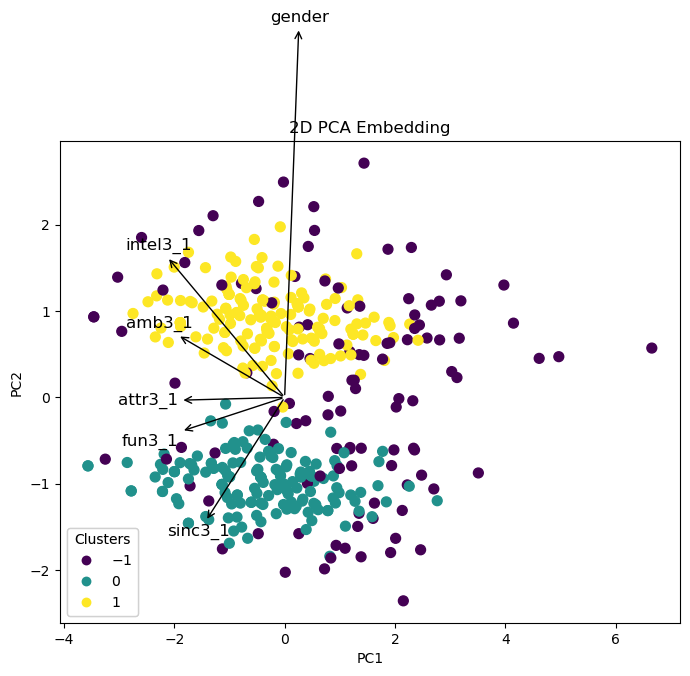

c:\Users\miejs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\miejs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


------- Wizualizacja osadzenia w 2D za pomocą t-SNE -------


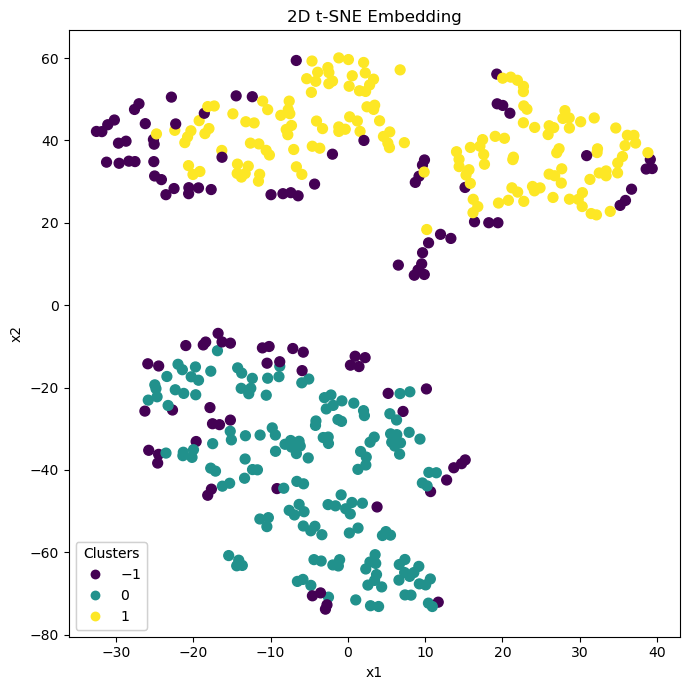

In [11]:
main(raw_data, features_subsets[0], min_sample_policy='+1', visualise_scaled=True)

### Case Study 2: Jakie ludzie mają potrzeby na tle ich płci

Następujący raport opisuje klasteryzację danych na zbiorze cech:
- `gender`, `amb1_1`, `attr1_1`, `sinc1_1`, `intel1_1`, `fun1_1`

i osadzenia klastrów w przestrzeni `2D` za pomocą `PCA` i `t-SNE`.

W wyniku zastosowania `DBSCAN` wyszły nam trzy klasy:
- `0`, `1` oraz `-1` (szum).

Za pomocą `PCA` możemy ocenić, jakie cechy najsilniej opisują różne klastry:
- `0` opisuje głównie kobiety. Kobiety głównie szukają partnerów ambitnych (`amb1_1`) oraz inteligentnych (`intel1_1`). Ponadto, chcą partnerów albo zabawnych (`fun1_1`) albo szczerych (`sinc1_1`).
- `1` opisuje głównie mężczyzn. Mężczyzni przede wszystkim szukają partnerek atrakcyjnych (`attr1_1`) oraz albo zabawnych (`fun1_1`) albo szczerych (`sinc1_1`).

Ciekawe spostrzeżenia:
- Niezależnie od płci, ludzie chcą albo kogoś zabawnego albo szczerego.

------- Klastry wraz z licznością -------
    count  frequency
 0    190   0.450237
 1    183   0.433649
-1     49   0.116114


------- Medianowe statystyki klastrów -------
            gender  intel1_1  shar1_1  attr1_1  sinc1_1  amb1_1  fun1_1
cluster_id                                                             
-1             1.0      16.0      5.0     45.0     10.0     1.0    15.0
 0             0.0      20.0     10.0     15.0     20.0    14.0    18.0
 1             1.0      20.0     10.0     25.0     16.0    10.0    20.0


------- Rozkład PCA na cechy -------
               PC1       PC2
gender    0.439418 -0.204457
intel1_1 -0.208163  0.188131
shar1_1  -0.342304 -0.300083
attr1_1   0.613276 -0.145884
sinc1_1  -0.309744 -0.474116
amb1_1   -0.410778  0.210142
fun1_1    0.074967  0.736564


------- Wizualizacja osadzenia w 2D za pomocą PCA -------


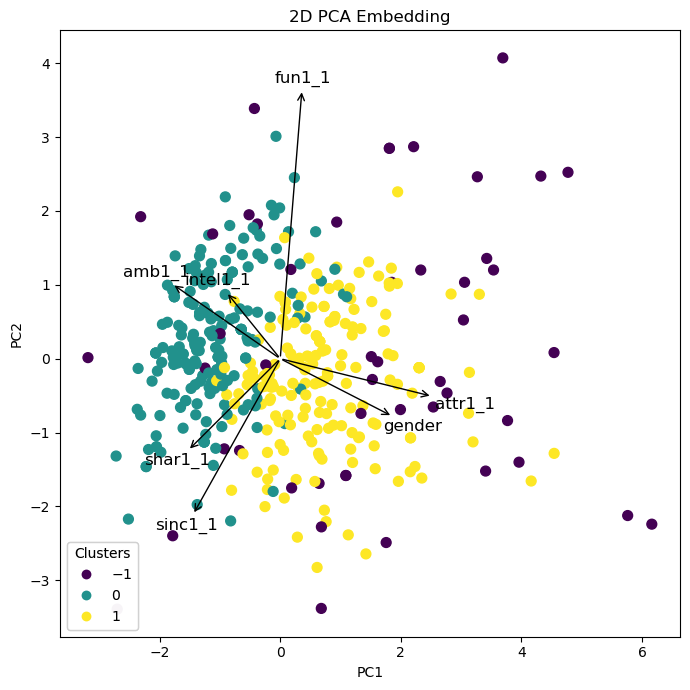

c:\Users\miejs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\miejs\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


------- Wizualizacja osadzenia w 2D za pomocą t-SNE -------


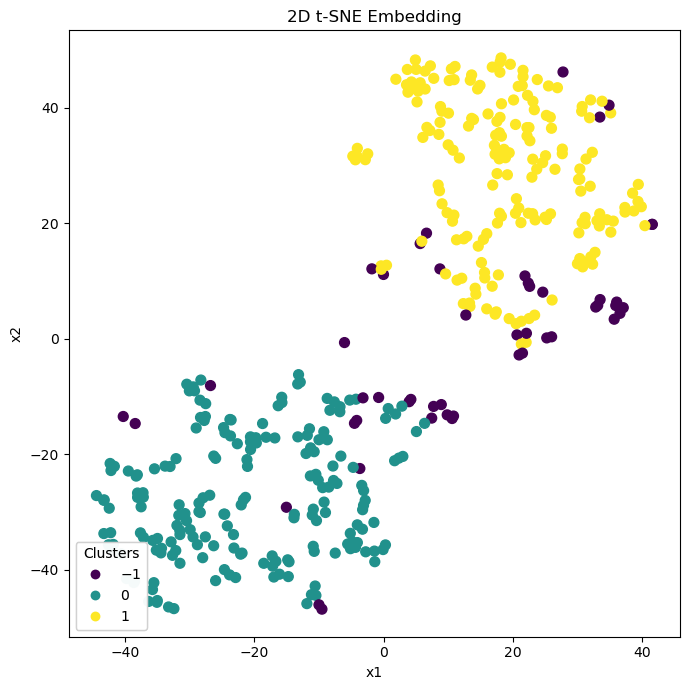

In [12]:
main(raw_data, features_subsets[1], min_sample_policy='+1', visualise_scaled=True)